Name - Sujoy Sarkar
Roll - 19AI91S01

In [0]:
import numpy as np
import zipfile
import glob
import pandas as pd
from torchvision import models
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim

import cv2
from time import time
import torch
import torch.optim as optim
from sklearn.model_selection  import train_test_split 
import torch.optim.lr_scheduler as Scheduler
import matplotlib.pyplot as plt

In [0]:
#Read label details of all images
train_labels=pd.read_csv('/content/drive/My Drive/PhD Coursework/DLFA/Covid19action-radiology-CXR_v1.1/Train_Combined.csv')
test_labels=pd.read_csv('/content/drive/My Drive/PhD Coursework/DLFA/Covid19action-radiology-CXR_v1.1/Test_Combined.csv')


In [52]:
train_labels.head()

,Image Name,Data Source,Partition,Non-Pneumonia,Other Pneumonia,COVID-19
0,CASE58_XRAY_1.jpeg,Source-2,1,0,0,1
1,case2_xray_1.jpeg,Source-2,1,0,0,1
2,case2_xray_2.jpeg,Source-2,1,0,0,1
3,case8_xray_1.jpeg,Source-2,1,0,0,1
4,case8_xray_2.jpeg,Source-2,1,0,0,1


In [53]:
#No of Positive and Negative Cases
train_labels['COVID-19'].value_counts()

0    228693
1       245
Name: COVID-19, dtype: int64

In [0]:
#Read file names of all images
image_paths = [f for f in glob.glob("/content/drive/My Drive/PhD Coursework/DLFA/Covid19action-radiology-CXR_v1.1/images/Source1/*")]
image_paths.extend([f for f in glob.glob("/content/drive/My Drive/PhD Coursework/DLFA/Covid19action-radiology-CXR_v1.1/images/Source2/*")])
image_paths.extend([f for f in glob.glob("/content/drive/My Drive/PhD Coursework/DLFA/Covid19action-radiology-CXR_v1.1/images/Source5/*")])

In [55]:
#Total No of Images
len(image_paths)

553

In [56]:
#Get Image names
image_list = pd.DataFrame(columns=['Image Name', 'Path'])
for path in image_paths:
  name = path.split('/')[-1]
  image_list = image_list.append({'Image Name':name, 'Path':path}, ignore_index=True)
print(image_list.shape)

(553, 2)


In [57]:
train_data = pd.merge(image_list,train_labels,on='Image Name')
print(train_data.shape)
train_data.head()

(291, 7)


,Image Name,Path,Data Source,Partition,Non-Pneumonia,Other Pneumonia,COVID-19
0,EUNO4YLXQAMnLsT.jfif,/content/drive/My Drive/PhD Coursework/DLFA/Co...,Source-1,4,0,0,1
1,EUNYm8SXYAEE8i8.jfif,/content/drive/My Drive/PhD Coursework/DLFA/Co...,Source-1,1,0,0,1
2,EUNQEglXkAM0MA0.jfif,/content/drive/My Drive/PhD Coursework/DLFA/Co...,Source-1,4,0,0,1
3,EUNT_GzXsAAxpdg.jfif,/content/drive/My Drive/PhD Coursework/DLFA/Co...,Source-1,3,0,0,1
4,EUNLaa6XkAA4k5p.jfif,/content/drive/My Drive/PhD Coursework/DLFA/Co...,Source-1,4,0,0,1


In [58]:
test_data = pd.merge(image_list,test_labels,on='Image Name')
print(test_data.shape)

(60, 6)


In [59]:
print('Train Data: \n',train_data['COVID-19'].value_counts())
print('Test data: \n',test_data['COVID-19'].value_counts())

Train Data: 
 1    244
0     47
Name: COVID-19, dtype: int64
Test data: 
 1    49
0    11
Name: COVID-19, dtype: int64


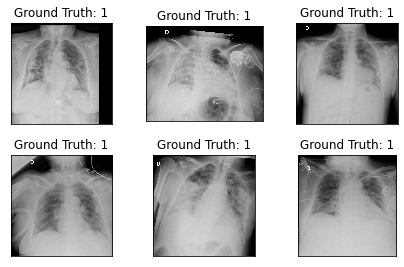

In [76]:
#Sample augmentated images
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    img=cv2.imread(train_label.loc[i]['Path'])
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(train_data.iloc[i]['COVID-19']))
    plt.xticks([])
    plt.yticks([])

In [60]:
#Pretrained Model - VGG16
model = models.vgg16(pretrained=True)

# No update of previous layers 
for param in model.parameters():
    param.requires_grad = False
n_inputs = model.classifier[6].in_features

# Add classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 3), nn.LogSoftmax(dim=1))

if train_on_gpu:
    model = model.to('cuda')



summary(model, input_size=(3, 224, 224), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

In [61]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,310,147 total parameters.
1,049,603 training parameters.


In [0]:

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [66]:
scheduler=Scheduler.ReduceLROnPlateau(optimizer,'min')
time0 = time()
epochs = 30
count=0
previous_running_loss_val=0
running_loss_val = 0
mpc=7
train_loss=[]
validation_loss=[]
validation_accuracy=[]
for e in range(epochs):
    previous_running_loss_val=running_loss_val
    running_loss_train = 0
    running_loss_val = 0
    pos_count=0
# Split training and validation data with validation size 15% of training.

    
    train_label, val_label = train_test_split(train_data, test_size=0.15,random_state=1)

    for i in train_label.index:
        labels=torch.from_numpy(np.expand_dims(np.array(train_label.loc[i][['Non-Pneumonia','Other Pneumonia','COVID-19']]).astype(np.int),0))
        img_name=train_label.loc[i]['Image Name']
        source=train_label.loc[i]['Data Source'].replace('-','')
        img=cv2.imread(train_label.loc[i]['Path'])
        img=cv2.resize(img,(224,224),interpolation=cv2.INTER_NEAREST)
        img=np.transpose(img)
        images=torch.from_numpy(np.expand_dims(img.astype('float32'),0))
        optimizer.zero_grad()
        
        output = model(images)
        loss =criterion(output, labels.argmax(dim=1))
        
        
        loss.backward()
        
        
        optimizer.step()
        
        running_loss_train += loss.item()

    for i in val_label.index:
        labels=torch.from_numpy(np.expand_dims(np.array(val_label.loc[i][['Non-Pneumonia','Other Pneumonia','COVID-19']]).astype(np.int),0))
        img_name=val_label.loc[i]['Image Name']
        source=val_label.loc[i]['Data Source'].replace('-','')
        img=cv2.imread(val_label.loc[i]['Path'])
        img=cv2.resize(img,(224,224),interpolation=cv2.INTER_NEAREST)
        img=np.transpose(img)
        images=torch.from_numpy(np.expand_dims(img.astype('float32'),0))

        
        
        output = model(images)
        
        loss =criterion(output, labels.argmax(dim=1))
        MAX=np.argmax(output.detach().numpy())
        if int(np.argmax(labels))==MAX:
          pos_count +=1
        
        
        running_loss_val += loss.item()

    else:
# Stopping criteria if for 7 epochs there is no improvement in validation loss i.e. change is <=.0001 then training stops 

        if abs(previous_running_loss_val/len(val_label)-running_loss_val/len(val_label))<=.0001:
          count +=1
        else:
          count=0
        if count==mpc:
          break;
        # Scheduler step
        scheduler.step(previous_running_loss_val)

        train_loss.append(running_loss_train/len(train_label))
        validation_loss.append(running_loss_val/len(val_label))
        validation_accuracy.append(pos_count/len(val_label))
        print("Epoch {} - Training loss: {}, Validation loss: {}, validation accuracy: {}".format(e, running_loss_train/len(train_label),running_loss_val/len(val_label),pos_count/len(val_label)))


Epoch 0 - Training loss: 0.7421119537485733, Validation loss: 0.8888045137361835, validation accuracy: 0.75
Epoch 1 - Training loss: 0.5923851285671828, Validation loss: 0.7209377597404537, validation accuracy: 0.7727272727272727
Epoch 2 - Training loss: 0.5906418995213104, Validation loss: 0.8906634466676141, validation accuracy: 0.8181818181818182
Epoch 3 - Training loss: 0.5658100693985704, Validation loss: 0.6133316614708003, validation accuracy: 0.8181818181818182
Epoch 4 - Training loss: 0.5618262142826679, Validation loss: 1.0010013117624277, validation accuracy: 0.75
Epoch 5 - Training loss: 0.5153880532340556, Validation loss: 0.5873144410010851, validation accuracy: 0.75
Epoch 6 - Training loss: 0.4839553483210526, Validation loss: 0.5998195607045834, validation accuracy: 0.7045454545454546
Epoch 7 - Training loss: 0.5142615679736925, Validation loss: 0.668672397937123, validation accuracy: 0.7727272727272727
Epoch 8 - Training loss: 0.592412559036868, Validation loss: 0.5471

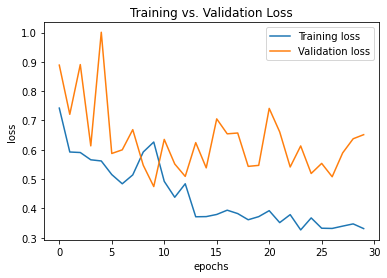

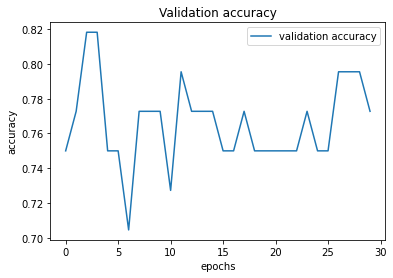


Training Time (in minutes) = 97.04996804396312


In [67]:

#Plotting Training and validation loss
x1 = range(epochs)
y1 = train_loss
plt.plot(x1, y1, label = "Training loss")
x2 = range(epochs)
y2 = validation_loss
plt.plot(x2, y2, label = "Validation loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()
x1=range(epochs)
y1=validation_accuracy
plt.plot(x1,y1,label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Validation accuracy')
plt.legend()
plt.show()
print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [73]:
pos_count=0
for i in test_data.index:
    labels=torch.from_numpy(np.expand_dims(np.array(test_data.loc[i][['Non-Pneumonia','Other Pneumonia','COVID-19']]).astype(np.int),0))
    img_name=test_data.loc[i]['Image Name']
    source=test_data.loc[i]['Data Source'].replace('-','')
    img=cv2.imread(test_data.loc[i]['Path'])
    img=cv2.resize(img,(224,224),interpolation=cv2.INTER_NEAREST)
    img=np.transpose(img)/255.0
    images=torch.from_numpy(np.expand_dims(img.astype('float32'),0))

    
    
    output = model(images)
    
    MAX=np.argmax(output.detach().numpy())
    if int(np.argmax(labels))==MAX:
      pos_count +=1
    
print('Testing accuracy is: {}'.format(pos_count/len(test_data)*100))

Testing accuracy is: 81.66666666666667
